In [14]:
import torch 
import torch.nn as nn 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchvision import transforms
from torch.utils.data import DataLoader, DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import os 
from torchvision.io import read_image

In [17]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

root_dir = '/mnt/c/Users/jon/Pictures/dataset'

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

dataset = ImageFolder(root=root_dir, transform=transform)

data_loader = DataLoader(dataset, batch_size = 100, shuffle = True)

for images, labels in data_loader:
    print(images.shape)  # Print the shape of the images batch
    print(labels)  # Print the labels for the images
    break  # Only print the first batch for demonstration


class_to_idx = dataset.class_to_idx

# Print the mapping of class names to labels
print(class_to_idx)


torch.Size([100, 3, 224, 224])
tensor([4, 3, 1, 1, 2, 3, 1, 3, 1, 2, 3, 1, 1, 1, 5, 2, 3, 2, 1, 1, 3, 2, 1, 1,
        2, 2, 4, 1, 1, 3, 3, 1, 1, 3, 5, 2, 1, 1, 1, 3, 4, 4, 2, 1, 1, 0, 5, 1,
        2, 1, 2, 2, 1, 3, 1, 4, 5, 1, 2, 4, 4, 1, 3, 1, 4, 1, 1, 4, 1, 4, 2, 4,
        4, 1, 3, 4, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 3, 1, 1, 2, 1, 2, 2, 1, 1, 2,
        2, 2, 1, 4])
{'iron': 0, 'medieval': 1, 'medievalAndHistoric': 2, 'reformation': 3, 'undated': 4, 'viking': 5}


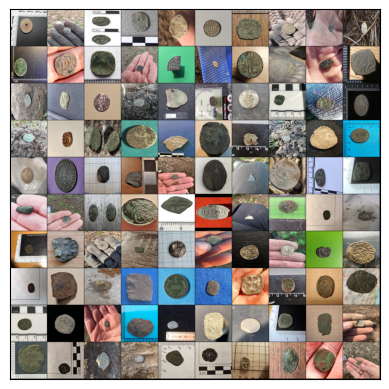

In [20]:
def show_image_grid(images: torch.Tensor, ncol: int): 
    image_grid = make_grid(
        images, 
        ncol
    ) # Make images into a grid 

    image_grid = image_grid.permute(1, 2, 0) # Move channel to the last 
    image_grid = image_grid.cpu().numpy() 

    plt.imshow(image_grid)
    plt.xticks([]) # Empty x and y labels 
    plt.yticks([])
    plt.show() 


show_image_grid(
    images = images, 
    ncol = 10
)

In [21]:
# Discriminator: Real or Fake
# Fake = Does not look like it is from MNIST 
# Real = Looks like it is from MNIST

epochs = 100
batch_size = 100
sample_size = 100 # Number of random values to sample 
g_lr = 1.0e-4 # Generator learning rate
d_lr = 1.0e-4 # Discriminator learning rate

class Generator(nn.Sequential):
    def __init__(self, sample_size: int):
        super().__init__(
            nn.Linear(sample_size, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )
        # Random value vector size
        self.sample_size = sample_size

    def forward(self, batch_size: int, z): 
        output = super().forward(z)
        generated_images = output.reshape(batch_size, 3, 224, 224) 
        return generated_images


class CNN_Discriminator(nn.Module):
    def __init__(self):
        super(CNN_Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0)  # Final conv layer with no padding
        self.relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.conv5(x)
        x = self.sigmoid(x)
        return x

folder_path = "/mnt/c/projs/Classification-and-3D-reconstruction-of-archaeological-artifacts/generated" 
def save_images_grid(epoch: int, images: torch.Tensor, ncol: int):
    image_grid = make_grid(images, ncol)     # Images in a grid
    image_grid = image_grid.permute(1, 2, 0) # Move channel last
    image_grid = image_grid.cpu().numpy()    # To Numpy

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    plt.imshow(image_grid)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(os.path.join(folder_path, f'generated_{epoch:03d}.jpg'))
    plt.close()